# Demo for GRAINet training & testing

This notebook is a demonstration of how to train and test the convolutional neural network used to analyze the grain size distributions in river beds over entire gravel bars (Lang et al., 2020).

Here, we use a small subset of the dataset presented in the study. I.e. a single gravel bar (orthophoto) with 212 manually annotated image tiles. The full dataset cannot be published for commercial reasons, as it is owned by a private company (who also created it at their own cost).

**Important notes**: 

The model trained with the small subset of data will not perform and generalize as described in the paper. However, this demo should help to get started.

After playing with this notebook, make sure to restart its kernel to free the GPU for other experiments.


### Checking the installation version

The code was tested with:
    
```
keras:  2.2.4
tensorflow:  1.13.1
h5py:  2.10.0
```

In [1]:
# to check the installed versions:
import keras
import tensorflow
import h5py

print('keras: ', keras.__version__)
print('tensorflow: ', tensorflow.__version__)
print('h5py: ', h5py.__version__)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

keras:  2.2.4
tensorflow:  1.13.1
h5py:  2.10.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

from train_test import run_train, run_test
from test_vis import create_plots
from inference_bank import run_prediction_orthophoto, read_rgb
from helper import setup_parser, collect_cv_data, create_k_fold_split_indices


### Setting arguments for the experiment



The default setting runs the experiment that regresses the mean diameter $d_m$ (scalar output) from the input image optimizing the mean squared error (MSE) as the loss function.

To regress and output the full grain size distribution, uncomment the code section below.

Please look at `helper.setup_parser` for detailed description of the arguments.

**Note**: The evaluation with qualitative plots of the predicted histograms will be saved in the experiment directory (`args.experiment_dir`), which is set below for each test fold.


In [3]:
# setup argument parser with default values
parser = setup_parser()
args, unknown = parser.parse_known_args()

# image dataset with ground truth 
args.data_npz_path = os.path.join('data_GRAINet_demo', 'data_KLEmme_1bank.npz')

# full orthophoto image (for predicting a map)
args.image_path = os.path.join('data_GRAINet_demo', 'orthophoto_KLEmme.tif')

# manually created mask to select regions of interest on the gravel bar
ortho_mask_path = os.path.join('data_GRAINet_demo', 'mask_dm_pred.tif')

# set output directory
parent_dir = 'output_demo_dm'
# evaluation metrics
metrics_keys = ('mae', 'rmse')

# UNCOMMENT to regress the full grain size distribution
#parent_dir = 'output_demo_pdf'
#args.output_dm = False
#args.loss_key = 'kld'
#metrics_keys = ('kld', 'iou')

args.verbose = 0  # minimal output. Set to 1 for progressbar etc.
args.nb_epoch = 20

if not os.path.exists(parent_dir):
    os.makedirs(parent_dir)

# print all arguments
for arg in vars(args):
    print('{}: {}'.format(arg, getattr(args, arg)))


verbose: 0
experiment_type: randCV
data_npz_path: data_GRAINet_demo/data_KLEmme_1bank.npz
bank_names_path: None
randCV_indices_path: None
experiment_dir: None
image_path: data_GRAINet_demo/orthophoto_KLEmme.tif
inference_path: None
img_rows: 500
img_cols: 200
channels: 3
bins: 21
batch_size: 8
nb_epoch: 20
base_lr: 0.0003
loss_key: mse
test_fold_index: 0
test_bank_name: None
volume_weighted: False
output_dm: True
downsample_factor: 1.0


### Random cross-validation: Split data into 10 random folds (non-overlapping subsets)

In [4]:
num_folds=10

# load dataset
data = np.load(args.data_npz_path, allow_pickle=True)
print('data keys: ', list(data.keys()))

# set output path to save indices (dataset wrapper will loaded these indices)
args.randCV_indices_path = os.path.join(parent_dir, 'random_{}_fold_indices.npy'.format(num_folds))

# create the non-overlapping data splits
indices_list = create_k_fold_split_indices(data=data, out_path=args.randCV_indices_path, num_folds=num_folds)

data keys:  ['images', 'histograms', 'tile_names', 'dm']


/home/nlang/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


### Run the training and evaluation

In [5]:
N_runs = 1
# to evaluate over all samples use:
# N_runs = num_folds 

for test_fold_index in range(N_runs):
    args.test_fold_index = test_fold_index
    
    args.experiment_dir = os.path.join(parent_dir, 'loss_{}'.format(args.loss_key), 'testfold_{}'.format(args.test_fold_index))
    print('******************')
    print('TEST FOLD: ', args.test_fold_index)
    print(args.experiment_dir)

    # train the CNN
    print('training...')
    run_train(args)
    
    # test the best solution on the test data
    print('testing...')
    run_test(args)
    create_plots(args)

******************
TEST FOLD:  0
output_demo_dm/loss_mse/testfold_0
training...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
testing...
model evaluation
Summary: Loss over the test dataset: 2.3151, MAE: 1.2290, MSE: 2.3151, RMSE: 1.5215
predicted_dm.shape:  (22,)
original_names_all.shape:  (22,)
tables saved


### Collect and evaluate cross-validation results  

In [6]:
_, _, dm_results_dict = collect_cv_data(parent_dir=parent_dir, loss_keys=(args.loss_key,))

print('Number of test samples: ', dm_results_dict[args.loss_key]['dm_pred'].shape)
print('Mean absolute error: {:.1f} cm'.format(np.mean(np.abs(dm_results_dict[args.loss_key]['dm_true'] - dm_results_dict[args.loss_key]['dm_pred']))))


loss:  mse
Number of fold directories: 1
Number of test samples:  (22,)
Mean absolute error: 1.2 cm


### Plot test results

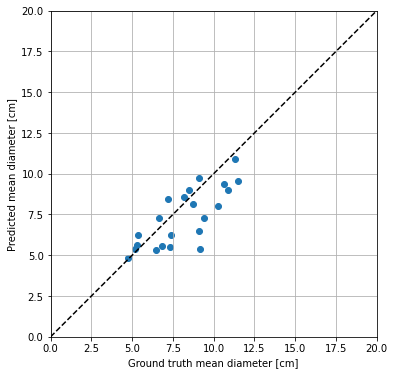

In [7]:
%matplotlib inline

if args.output_dm:
    mi, ma = 0, 20
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.scatter(dm_results_dict[args.loss_key]['dm_true'], dm_results_dict[args.loss_key]['dm_pred'])
    plt.xlabel('Ground truth mean diameter [cm]')
    plt.ylabel('Predicted mean diameter [cm]')
    plt.axis('square')
    plt.xlim(mi, ma)
    plt.ylim(mi, ma)
    plt.plot((mi, ma), (mi, ma), 'k--')
    plt.grid()


### Plot test samples in the first subset (testfold with index 0)

(22,)


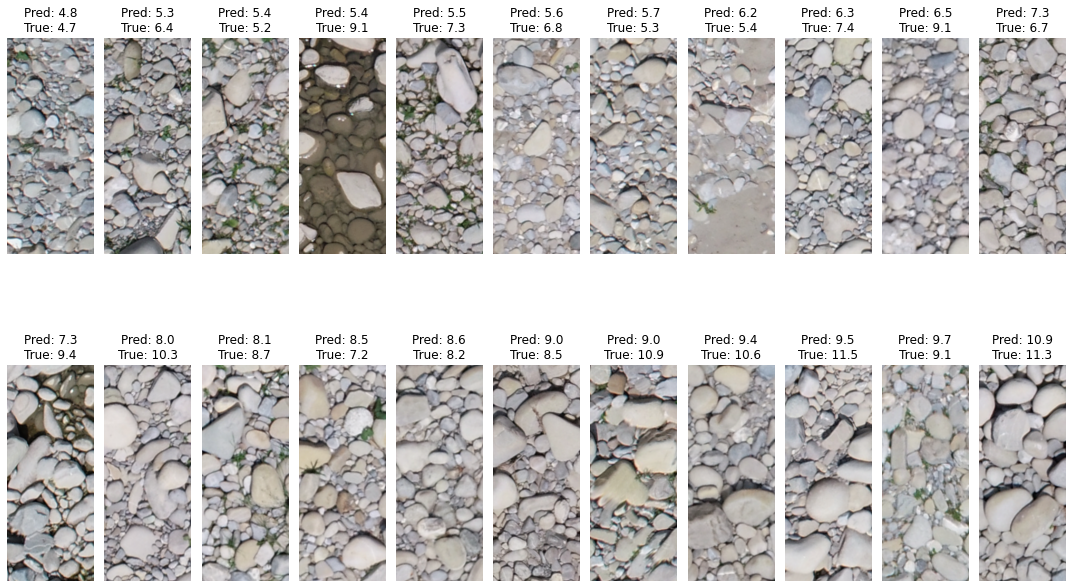

In [8]:
N_plots = len(indices_list[0])  # number of samples in fold 0
fig, axes = plt.subplots(nrows=2, ncols=int(N_plots/2), figsize=(15,10))
axes = axes.flatten()
predictions_fold_0 = dm_results_dict[args.loss_key]['dm_pred'][0:N_plots]
print(predictions_fold_0.shape)

# sort samples based on predictions
sorted_indices = np.argsort(predictions_fold_0)

for ax_i in range(len(sorted_indices)):
    ax=axes[ax_i]
    i = sorted_indices[ax_i]
    sample_i = indices_list[0][i]

    ax.imshow(np.array(data['images'][sample_i], dtype=np.uint8))
    ax.axis('off')
    ax.set_title('Pred: {:.1f}\nTrue: {:.1f}'.format(dm_results_dict[args.loss_key]['dm_pred'][i], dm_results_dict[args.loss_key]['dm_true'][i]))    
        
plt.tight_layout()

# Predict the mean diameter map for the entire orthophoto

In [9]:
if args.output_dm:
    # predict with model from last fold
    args.inference_path = args.experiment_dir
    predictions_ortho, predictions_2D_map, orthophoto = run_prediction_orthophoto(args)


downsample_factor:  1.0
band_array.shape:  (24719, 21028)
band_array.shape:  (24719, 21028)
band_array.shape:  (24719, 21028)
img_rows, img_cols: 24719 21028
tile_rows: 500.0, tile_cols: 200.0
num tiles row:  49
num tiles col:  105
total tiles : 5145
tiles.shape: (5145, 500, 200, 3)
pred_shape:  (49, 105)
predictions.shape:  (5145, 1)
dm_preds.shape: (5145, 1)
dm_pred_reshaped.shape:  (49, 105)
band_array.shape:  (24719, 21028)
band_array.shape:  (24719, 21028)
band_array.shape:  (24719, 21028)


### Visualize orthophoto and prediction map (mean diameter)

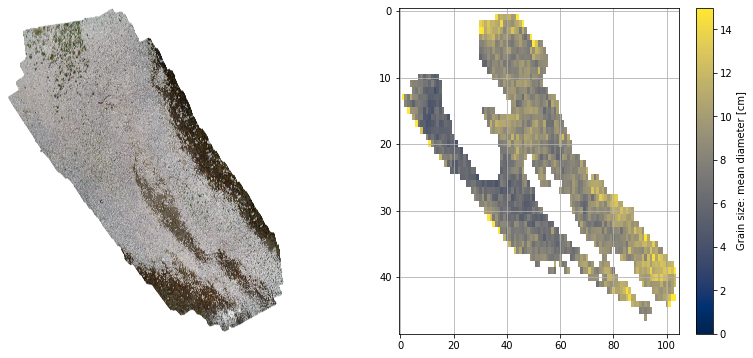

In [10]:
%matplotlib inline

# mask the prediction map
mask = np.array(Image.open(ortho_mask_path))
predictions_2D_map_masked = np.ma.masked_where(mask!=1, predictions_2D_map)

if args.output_dm:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

    # plot ortho RGB image
    orthophoto = np.array(orthophoto, dtype=np.uint8)
    axes[0].imshow(orthophoto)
    axes[0].axis('off')

    # plot prediction map
    pred_map = axes[1].imshow(predictions_2D_map_masked, aspect=500/200, cmap='cividis', 
                              vmin=0, vmax=15, interpolation='nearest')
    plt.colorbar(mappable=pred_map, label='Grain size: mean diameter [cm]')
    axes[1].grid()
